In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

In [20]:
# Reading Dataset
data = pd.read_csv('fer2013.csv')
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [21]:
# Checking Shape of data
data.shape

(35887, 3)

## Data Visualization

In [22]:
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
label_to_text

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'happiness',
 4: 'sadness',
 5: 'surprise',
 6: 'neutral'}

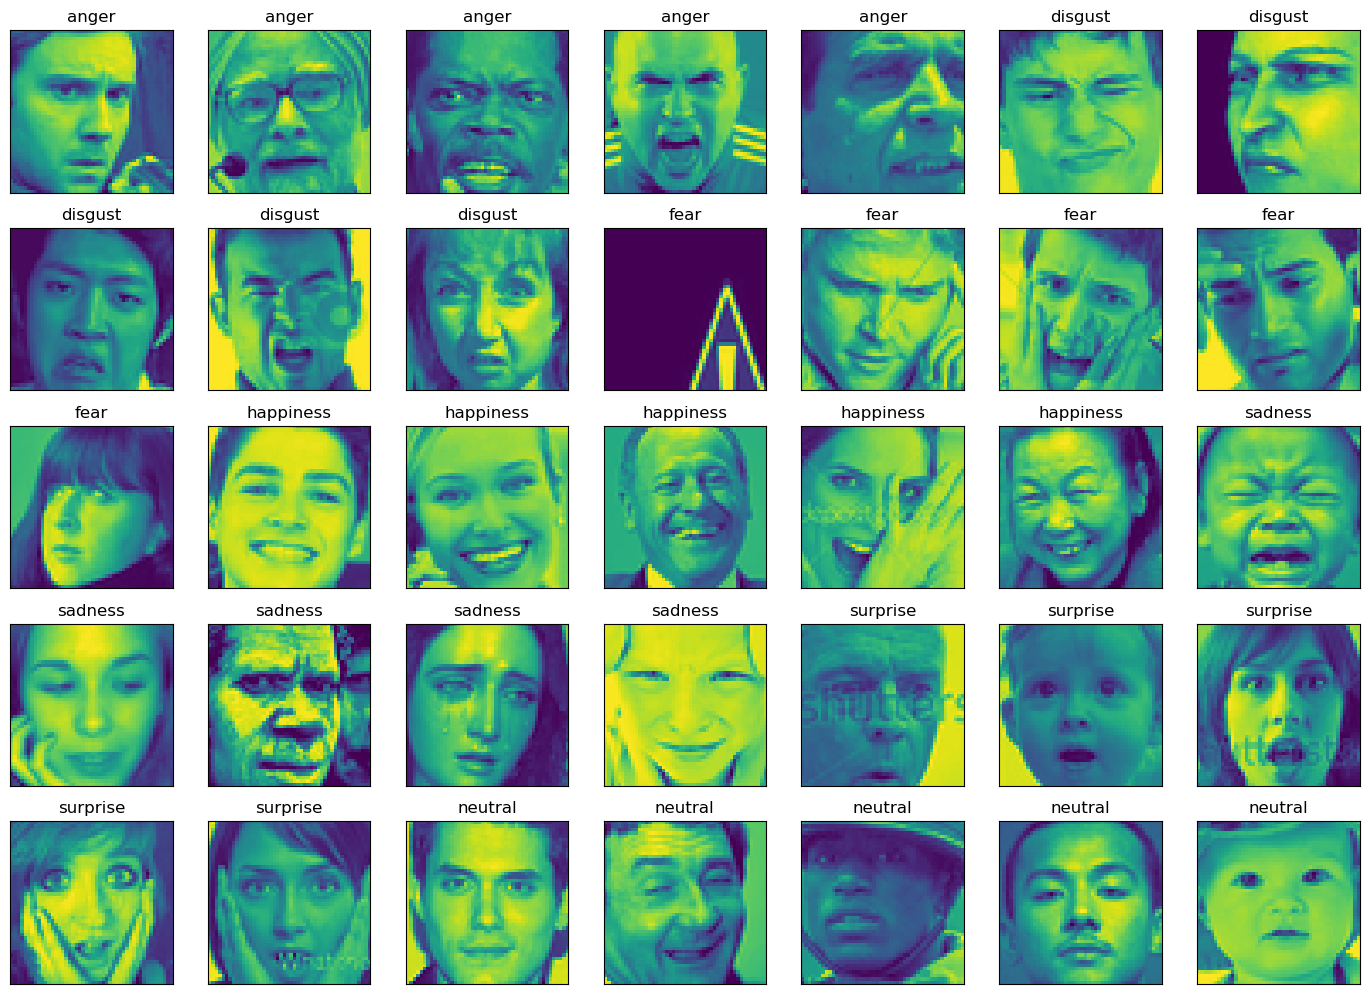

In [23]:
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(data.emotion.unique()):
    for j in range(5):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()

In [24]:
# Checking Emotion Class Distribution
data['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

C:\Users\HP\AppData\Local\Temp\ipykernel_6880\3157755877.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="emotion_name", data=data, palette=colors)


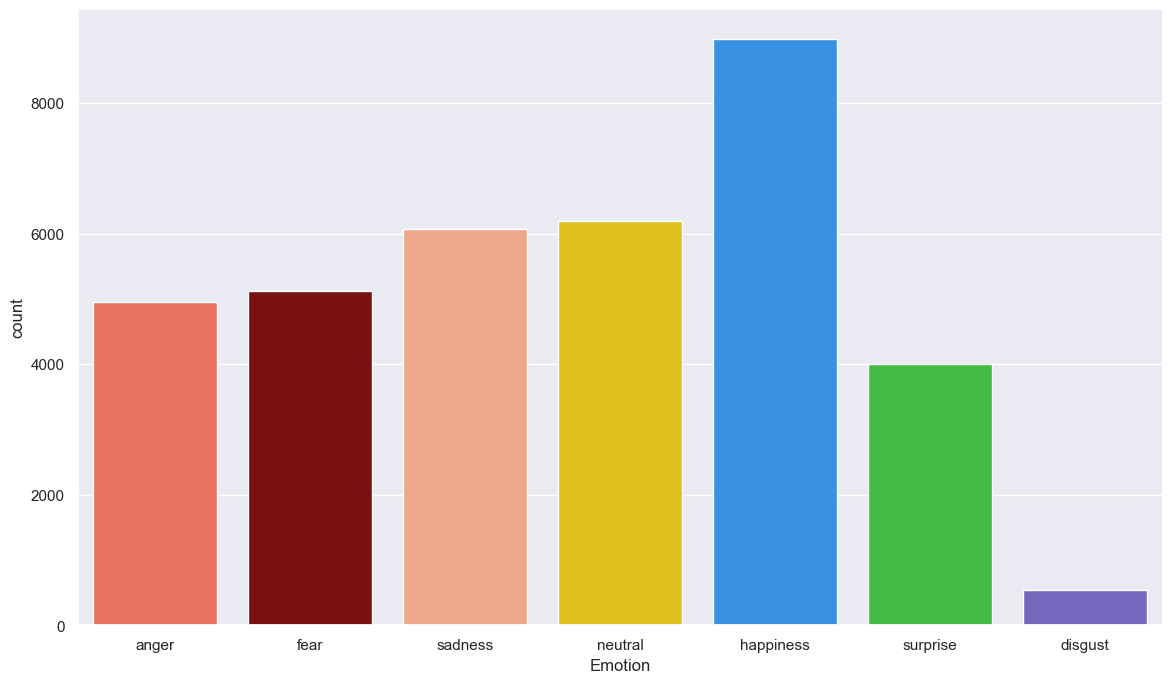

In [31]:
# Define a color palette with distinct colors for each emotion
colors = ["#FF6347", "#8B0000", "#FFA07A", "#FFD700", "#1E90FF", "#32CD32", "#6A5ACD"]

# Plotting the distribution with labels and custom colors
plt.figure(figsize=(14, 8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion_name", data=data, palette=colors)
ax.set_xlabel("Emotion")
plt.show()

## Data Pre-processing (Balancing & Preparation)

In [32]:
# Split the data into feature & target variable
x_data = data['pixels']
y_data = data['emotion']

In [33]:
# Perform Random Over Sampling to balance the data
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [34]:
# Let's check the distribution of target data again after balancing
y_data.value_counts()

emotion
0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: count, dtype: int64

In [36]:
#Flatten
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    122 125 129 106 101 88 95 91 71 79 72 87 90 76...
62919    148 144 130 129 119 122 129 131 139 153 140 12...
62920    89 82 37 19 24 30 30 35 44 61 76 116 139 141 1...
62921    65 68 70 71 70 74 78 84 89 94 94 92 92 94 100 ...
62922    136 132 84 57 54 51 43 42 41 41 45 40 45 40 43...
Length: 62923, dtype: object

In [37]:
# Normalize the data
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [38]:
# Reshaping
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

In [39]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [40]:
# Split the data and create train-test set
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

In [41]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((56630, 48, 48, 1), (6293, 48, 48, 1), (56630, 1), (6293, 1))

In [43]:
# Perform One-Hot Encoding on training data
y_train = to_categorical(y_train, 7)
y_train.shape

(56630, 7)

In [45]:
# Perform One-Hot Encoding on test data
y_test = to_categorical(y_test, 7)
y_test.shape

(6293, 7)

## Model Building

In [46]:
model = Sequential([
    # 1st Conv Layer
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 2nd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 3rd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 4th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 5th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Flattening the Layer
    Flatten(),

    # Hidden Layer
    Dense(250, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(7, activation = 'softmax')
])

In [47]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 46, 46, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 8, 8, 128)           │              

 Total params: 792,855 (3.02 MB)

 Trainable params: 792,023 (3.02 MB)

 Non-trainable params: 832 (3.25 KB)

## Model Training

In [60]:
# Compile the Model
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
# Train the Model
history = model.fit(x_train, y_train, epochs = 35, validation_data=(x_test, y_test))

Epoch 1/35
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 496s 276ms/step - accuracy: 0.2288 - loss: 1.9604 - val_accuracy: 0.3896 - val_loss: 1.6021
Epoch 2/35
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 443s 250ms/step - accuracy: 0.3846 - loss: 1.5942 - val_accuracy: 0.4650 - val_loss: 1.4012
Epoch 3/35
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 435s 246ms/step - accuracy: 0.4654 - loss: 1.4105 - val_accuracy: 0.5061 - val_loss: 1.2706
Epoch 4/35
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 409s 231ms/step - accuracy: 0.5175 - loss: 1.2813 - val_accuracy: 0.5427 - val_loss: 1.1776
Epoch 5/35
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 405s 229ms/step - accuracy: 0.5495 - loss: 1.1893 - val_accuracy: 0.5884 - val_loss: 1.0673
Epoch 6/35
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 401s 226ms/step - accuracy: 0.5752 - loss: 1.1155 - val_accuracy: 0.5822 - val_loss: 1.0958
Epoch 7/35
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 457s 258ms/step - accuracy: 0.6001 - loss: 1.0543 - val_accuracy: 0.5994 - val_loss: 1.0331
Epoch 8/35
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 480s 271ms/step - ac

## Model Evaluation

In [62]:
print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")
print("Loss of our model on test data : " , model.evaluate(x_test, y_test)[0])

197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8088 - loss: 0.6063
Accuracy of our model on test data :  81.05831742286682 %
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.8088 - loss: 0.6063
Loss of our model on test data :  0.5921215415000916


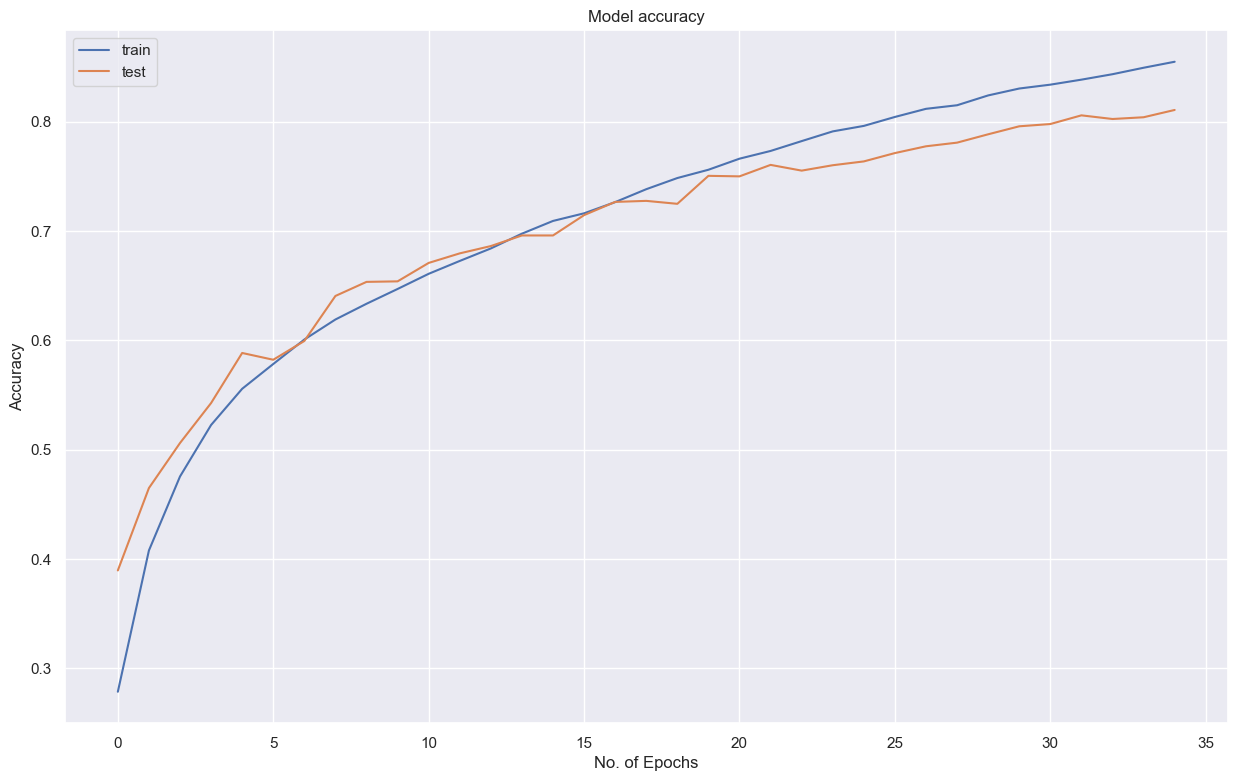

In [63]:
plt.figure(figsize=(15, 9))

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

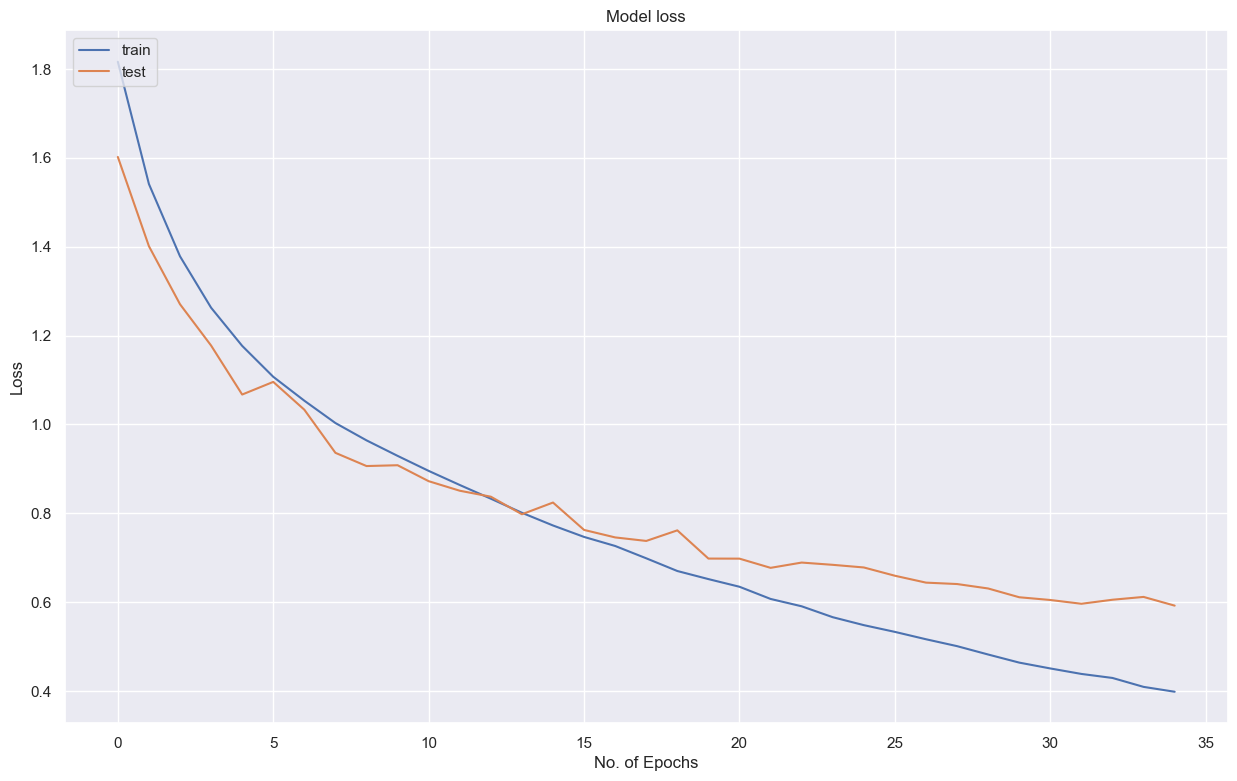

In [64]:
plt.figure(figsize=(15, 9))

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Getting Classification Report & Plotting Confusion Matrix

In [65]:
# Making Predictio on Test Data
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step


[6, 5, 2, 6, 1, 0, 3, 4, 1, 3]

In [66]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[6, 5, 5, 6, 1, 0, 3, 4, 1, 3]

In [67]:
# Getting Classification Report
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       935
           1       0.98      1.00      0.99       895
           2       0.78      0.70      0.74       880
           3       0.85      0.81      0.83       906
           4       0.66      0.72      0.69       888
           5       0.93      0.91      0.92       869
           6       0.72      0.75      0.73       920

    accuracy                           0.81      6293
   macro avg       0.81      0.81      0.81      6293
weighted avg       0.81      0.81      0.81      6293



Text(179.75, 0.5, 'Truth')

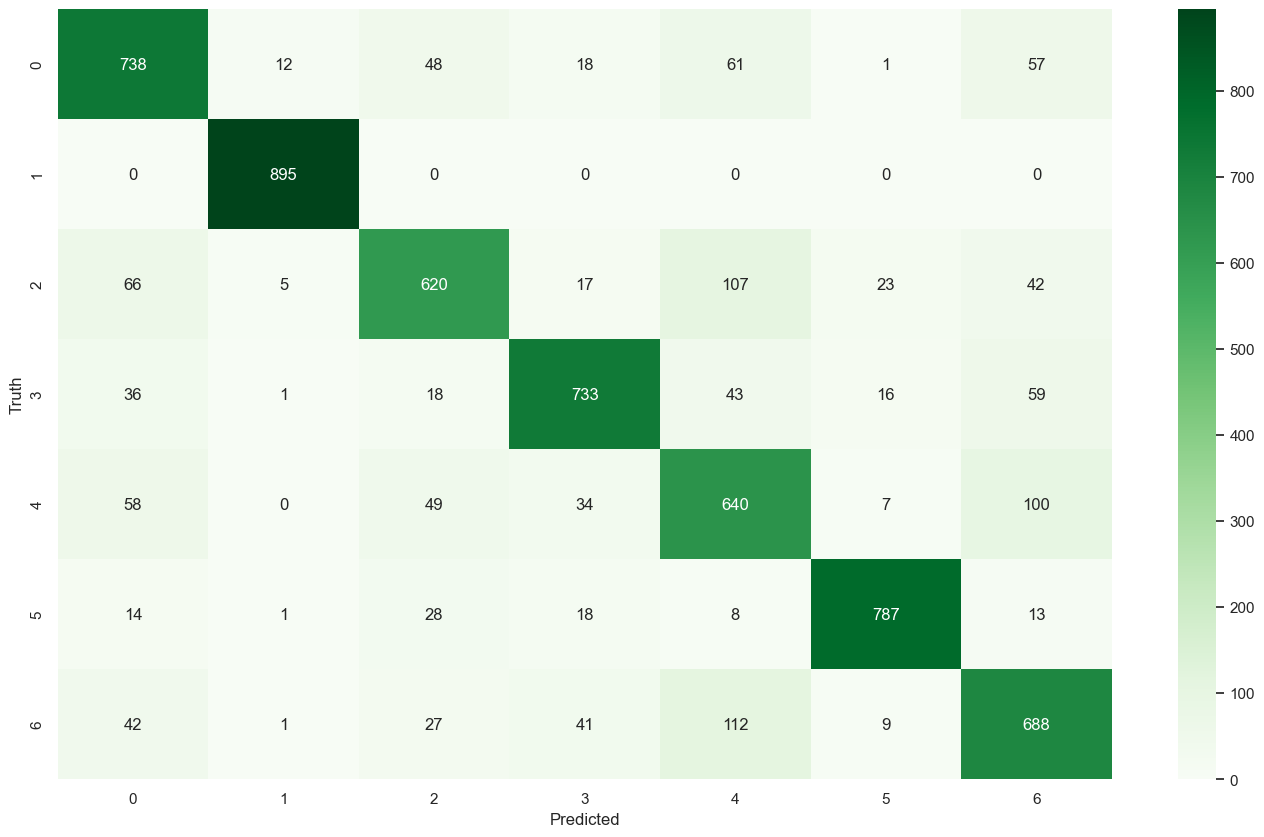

In [68]:
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (17, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Save the Model

In [69]:
# Save the Model
model.save("Facial_Expression_Detection_System.hdf5")

In [71]:
#Saving the  model to  use it later on
fer_json = model.to_json()
with open("Facial Expression Recognition.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.weights.h5")

##  Making Prediction in a Real-Time

In [ ]:
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image

# Load model architecture and weights
try:
    with open("Facial Expression Recognition.json", "r") as json_file:
        model = model_from_json(json_file.read())
    model.load_weights('fer.weights.h5')
except FileNotFoundError:
    print("Model files not found. Ensure JSON and weights files are in the directory.")
    exit()

# Load the Haar cascade for face detection
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
if face_haar_cascade.empty():
    print("Cascade file not found. Ensure haarcascade_frontalface_default.xml is in the directory.")
    exit()

# Start capturing video from the webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not access the webcam.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame.")
        break

    # Convert to grayscale for face detection
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_haar_cascade.detectMultiScale(gray_frame, scaleFactor=1.32, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Draw rectangle around the face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), thickness=2)

        # Preprocess the face for emotion detection
        roi_gray = gray_frame[y:y + h, x:x + w]
        roi_gray = cv2.resize(roi_gray, (48, 48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis=0)
        img_pixels /= 255.0  # Normalize pixel values

        # Predict emotion
        predictions = model.predict(img_pixels)
        max_index = np.argmax(predictions[0])
        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]

        # Overlay emotion text on the frame
        cv2.putText(frame, predicted_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Display the video with emotion detection
    cv2.imshow('Facial Emotion Analysis', frame)

    # Exit on pressing 'q'
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 26 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━